## Check GPU access and import required things

In [ ]:
#!nvidia-smi                       # uncomment to check if you have GPU access

import os

HOME = os.getcwd()
print(HOME)

# Pip install ultralytics

!pip install ultralytics==8.0.20


# gradio for demonstrations
!pip install -q gradio
import gradio as gr

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image as img
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import re
import yaml



Ultralytics YOLOv8.0.11 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.9/107.7 GB disk)


In [ ]:
## Download the dataset to google colab, or if running locally, get it from "data/processed"

## The model file " .pt" must be manually uploaded, for performing detections, if run on google colab, or selected from "models" folder

!mkdir {HOME}/datasets
%cd {HOME}/datasets


!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY_HERE")        # use your own roboflow API key (free to create a user, and use API key), dont share it widely.
project = rf.workspace("container").project("containerletters")
dataset = project.version(2).download("yolov8")


In [ ]:
##function to rename pictures(dataset pictures have very long names) to make it easier to work with

def rename_pictures(folder_path):
    i = 1
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            new_name = "test" + str(i) + os.path.splitext(filename)[1]
            os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_name))
            i += 1


In [ ]:

folder_path="/content/datasets/Continers-ocr-3/test/images"


# (Optional) 
rename_pictures(folder_path)


## train a YOLOv8 object detection model on your labeled data

In [ ]:
# for training, the epoch number is how many iterations of training over the data the model should perform (higher number takes longer, but might give better inference results)
# device=0 means use GPU, batch is the batchsize to use, "-1" finds the highest batch size your GPU supports (depends on the amount of VRAM your GPU has)
# if you are transfer learning from a previous model, then specify, if you want to train "from scratch" do not include the model param


# !yolo task=detect mode=train model="bestChar4.pt" data="datasets/containerletters-2/data.yaml" epochs=125 device=0 batch=-1 imgsz=640 plots=True

## Inference(predict) with custom pretrained yolov8 model



In [ ]:
#on pictures/videos thats uploaded to Google colab, or any folder from local machine, change "source" to link to a folder, or single image/video
#

#task = what you want to do, for exmaple, train a new model or detect with a pretrained model
#conf = how confident the model must be with the object detection to actually report it as a detection

%cd {HOME}
!yolo task=detect mode=predict model={HOME}/bestChar45.pt conf=0.30 save_txt=True hide_conf=True line_thickness=1 save=True source="/content/datasets/containerletters-2/test/images"

## Helper functions to turn the model prediction from individual chars to String

In [ ]:

#from PIL import Image

def get_string_txt(folder_path, text_folder_path, processing_function):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            text_file_path = os.path.join(text_folder_path, os.path.splitext(filename)[0]+ ".txt")
            image = img.open(image_path)
            processed_data = processing_function(text_file_path)
            text_path = os.path.splitext(image_path)[0] + ".txt"
            text_path = str(text_path)
            with open(text_path, "w") as text_file:
                text_file.write(str(processed_data))


In [ ]:
#go from yolo relative bounding box to actual bounding box

def relative_to_fixed(bounding_boxes_file, image ):

    dh, dw, _ = image.shape
    class_id, x_center, y_center, w, h = bounding_boxes_file
    x_center, y_center, w, h = float(x_center), float(y_center), float(w), float(h)
    x_center = round(x_center * dw)
    y_center = round(y_center * dh)
    w = round(w * dw)
    h = round(h * dh)
#    x_center = (x_center * dw)
#    y_center = (y_center * dh)
#    w = (w * dw)
#    h = (h * dh)
  #  x = round(x_center - w / 2)
    x = round(x_center)
    y = round(y_center - h / 2)
   # y = round(y_center)
    return (class_id, x, y, w, h)




In [ ]:
#combining the bounding boxes to go from chars -> words

def combine_bounding_boxes(bounding_boxes_file):
    min_x = float("inf")
    min_y = float("inf")
    max_x = 0
    max_y = 0
    labels = []
    bounding_boxes = []
    yaml_file ="/content/datasets/Continers-ocr-3/data.yaml"
#    with open(yaml_file, 'r') as f:
#         class_mapping = yaml.load(f, Loader=yaml.FullLoader)
    with open('/content/datasets/Continers-ocr-3/data.yaml') as f:
         class_mapping = yaml.safe_load(f)
  #       print(class_mapping.items())
  #       print(list(class_mapping))
    with open(bounding_boxes_file, 'r') as f:
        for line in f:
            label, x, y, w, h = line.strip().split()
            x1, y1, x2, y2 = float(x), float(y), float(x) + float(w), float(y) + float(h)
            bounding_boxes.append((x1, y1, x2, y2, label))
    # sort the bounding boxes based on their x and y coordinates
    bounding_boxes.sort(key=lambda x: (x[0], x[1]))   # (x[0], x[1])) for horizontal, switched for vertical
    for box in bounding_boxes:
    #    print(box[4])
    #    print(type(box[4]))
    #    labels.append(class_mapping.get(int(box[4])))
        labels.append(class_mapping["names"][int(box[4])])
    #    print(labels)
        min_x = min(min_x, box[0])
        min_y = min(min_y, box[1])
        max_x = max(max_x, box[2])
        max_y = max(max_y, box[3])
    combined_label = "".join(labels)
    return (combined_label, min_x, min_y, max_x-min_x, max_y-min_y)


In [ ]:
picture_path = "/content/runs/detect/predict"
label_path="/content/runs/detect/predict/labels"

get_string_txt(picture_path, label_path, combine_bounding_boxes)

## Visual example

('WBGBU50306234', 0.269231, 0.21274, 0.5324513000000001, 0.25961599999999996)


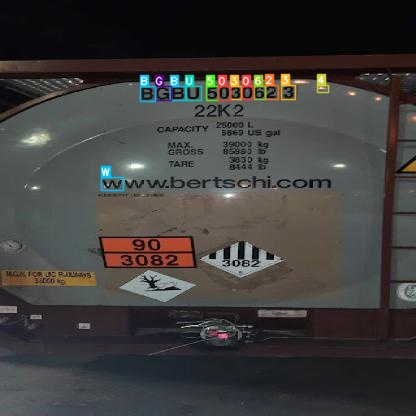

In [ ]:
#display prediction

path_to_predicted = "/content/runs/detect/predict"

#choose random test set image

pictures = []
for filename in os.listdir(path_to_predicted):
  if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
    file_path = os.path.join(path_to_predicted, filename)
    pictures.append(file_path)
    random_picture = random.choice(pictures)

jpg_folder, jpg_filename = os.path.split(random_picture)
txt_filename, _ = os.path.splitext(jpg_filename)
txt_filename += ".txt"
txt_location = os.path.join(jpg_folder, txt_filename)


random_picture_label = txt_location


# Load the image

image = cv2.imread(random_picture)
predictions=random_picture_label
# Get the new bounding box coordinates

#print label
#print(combine_bounding_boxes(predictions))
with open(random_picture_label, 'r') as file:
        print(file.read())

# Display the image
cv2_imshow(image)


## Validate predictions with custom pretrained yolov8 model



In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/bestChar3.pt data=/content/datasets/Continers-ocr-3/data.yaml

## Simple Gradio app to demonstrate

In [ ]:

original_picture_folder ="/content/datasets/Continers-ocr-3/test/images"

def demonstration():
    #choose random test set image

  pictures = []
  for filename in os.listdir(path_to_predicted):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
     file_path = os.path.join(path_to_predicted, filename)
     pictures.append(file_path)
     random_picture = random.choice(pictures)

  jpg_folder, jpg_filename = os.path.split(random_picture)
  txt_filename, _ = os.path.splitext(jpg_filename)
  txt_filename += ".txt"
  txt_location = os.path.join(jpg_folder, txt_filename)

  originaL_picture = os.path.join(original_picture_folder, jpg_filename)

  random_picture_label = txt_location

  with open(txt_location, 'r') as file:
      text = file.read()
  # Open the images
  img1 = img.open(originaL_picture)
  img2 = img.open(random_picture)
  return img1, img2,text

gr.Interface(fn=demonstration,
             title = "Container Code Identification V1",
             description = "Made by Alexander - Proof of concept for early demonstration only.",
             inputs=None,
             outputs=["image", "image", "text"]).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://332786e3-a5b0-4495.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [ ]:
#if you want to download folders from Google colab, zip with this first

import shutil
shutil.make_archive('demoApp28_01', 'zip', '/content/runs/detect')